In [1]:
import matplotlib.pyplot as plt
import deepdish as dd
from brian2.only import *
import numpy_ as np
import model
from spike_utils import iterspikes
from conf.params import params

First, find the E-E indegree distribution:

Minimum: 13
Median: 40.0
Maximum: 72


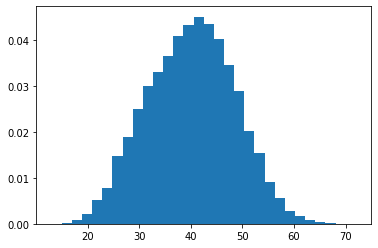

In [2]:
import conf.isi5_mouse as cfg
indegrees = []
for net in range(cfg.N_networks):
    try:
        res = dd.io.load(cfg.netfile.format(net=net))
    except:
        pass
    EE = res['W'][:cfg.params['N_exc'], :cfg.params['N_exc']]
    indegrees.append((EE>0).sum(0))

indegrees = np.asarray(indegrees).flatten()
plt.hist(indegrees, bins=30, density=True)
print('Minimum:', np.min(indegrees))
print('Median:', np.median(indegrees))
print('Maximum:', np.max(indegrees))
max_indegree = np.max(indegrees)

Next, probe the memory of threshold adaptation:

In [3]:
defaultclock.dt = params['dt']

In [4]:
def get_singular_input(N_inputs, period):
    return SpikeGeneratorGroup(N_inputs, np.arange(N_inputs), np.zeros(N_inputs)*ms, sorted=True, period=period, name='Input')

In [5]:
def get_probe(params, Input, record):
    params = params.copy()
    params['N_exc'] = 1

    Net = Network()
    Exc = model.create_excitatory(Net, X=[0*mm], Y=[0*mm], params=params, clock=defaultclock, extras=record, enforced_spikes=False, suffix='')
    Syn = model.make_exc_synapse(Input, Exc, np.arange(Input.N), np.zeros(Input.N, int), params['w_exc_mean'], params, name='Syn')

    XM = SpikeMonitor(Exc, record=[0], name='XM')
    if len(record):
        SM = StateMonitor(Exc, variables=record, record=[0], name='SM')
        Net.add(SM)

    Net.add(Input, Syn, XM)
    return Net

In [6]:
def get_recovery_time(params, N_inputs, N_pulses, input_creation_fn, isi=1*second, min_isi=10*msecond, record=(), exact=False):
    isi = int(isi/params['dt'])
    recovery_time = np.zeros(len(N_inputs))*second
    outputs = []
    for i, inputs in enumerate(N_inputs):
        lower_bound, upper_bound = int(min_isi/params['dt']), None
        initial = True
        while True:
            Input = input_creation_fn(inputs, isi*params['dt'])
            Net = get_probe(params, Input, record)
            Net.run((N_pulses+1)*isi*params['dt'])
            if Net['XM'].t[:].size == 0:
                upper_bound = np.nan
                break

            recovered = True
            for j, (_, x) in enumerate(iterspikes(Net['XM'].t, Net['XM'].t, (N_pulses+1), isi*params['dt'], dt=params['dt'])):
                if exact:
                    x = ((x + params['dt']/2) / params['dt']).astype(int)
                    if j == 0:
                        n0 = x
                    elif len(n0) != len(x) or np.unique(x-n0).size > 1:
                        recovered = False
                        break
                else:
                    if j == 0:
                        n0 = len(x)
                    elif len(x) != n0:
                        recovered = False
                        break

            if recovered:
                upper_bound = isi
                initial = False
            else:
                lower_bound = isi
            if initial:
                upper_bound = 2*isi
            elif upper_bound - lower_bound < 2:
                break
            isi = int((lower_bound+upper_bound)/2)
        recovery_time[i] = upper_bound*params['dt']
        if isi != upper_bound and upper_bound > 0:
            Input = input_creation_fn(inputs, upper_bound*params['dt'])
            Net = get_probe(params, Input, record)
            Net.run((N_pulses+1)*upper_bound*params['dt'])
        outputs.append({
            'V': Net['SM'].v.T,
            'g': Net['SM'].g_exc.T,
            'th': (Net['SM'].th_adapt.T if hasattr(Net['SM'], 'th_adapt') else 0*mV) + params['v_threshold'],
            'spiketimes': Net['XM'].t[:]
        })
    return recovery_time, outputs

In [7]:
def plot_explanatory_figure(params, isi, p1, V, g, th, spiketimes, tmax=None):
    isi = int((isi + params['dt']/2) / params['dt'])
    tmax = isi if tmax is None else int((tmax + params['dt']/2) / params['dt'])
    t = np.arange(isi)*params['dt'] / msecond
    fig, axs = plt.subplots(2, figsize=(6,6), constrained_layout=True)
    axs[0].plot(V[:tmax]/mV, c='C0', ls='--', alpha=.5)
    if p1 > 1:
        axs[0].plot(V[(p1-1)*isi : (p1-1)*isi + tmax]/mV, c='C0', alpha=.7)
    axs[0].plot(V[p1*isi : p1*isi + tmax]/mV, c='C0', label='Membrane voltage')
    try:
        for _ in th:
            break
        axs[0].plot(th[:tmax]/mV, c='C2', ls='--', alpha=.5)
        if p1 > 1:
            axs[0].plot(th[(p1-1)*isi : (p1-1)*isi + tmax]/mV, c='C2', alpha=.7)
        axs[0].plot(th[p1*isi : p1*isi + tmax]/mV, c='C2', label='Firing threshold')
    except TypeError:
        axs[0].axhline(th/mV, c='C2', label='Firing threshold')
    axs[0].set_ylabel('Voltage (mV)')
    axs[0].set_xlabel('Time (ms)')
    axs[0].legend()

    axs[1].plot(g[:tmax], c='C1', ls='--', alpha=.5)
    if p1 > 1:
        axs[1].plot(g[(p1-1)*isi : (p1-1)*isi + tmax], c='C1', alpha=.7)
    axs[1].plot(g[p1*isi : p1*isi + tmax], c='C1')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Synaptic conductance')

In [8]:
recovery_TA, out = get_recovery_time(
    {**params, 'tau_rec': 0*ms}, np.arange(max_indegree)+1, 1, get_singular_input,
    isi=params['th_tau'], record=('v', 'th_adapt', 'g_exc'))

WARNING    'dt' is an internal variable of group 'Exc', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


11. * msecond

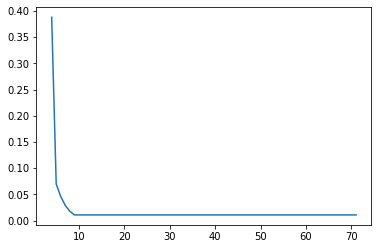

In [9]:
plt.plot(recovery_TA)
recovery_TA[-1]

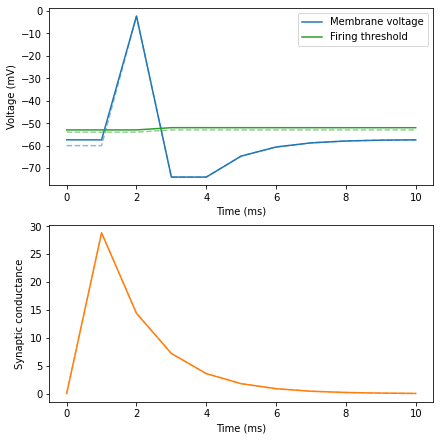

In [10]:
plot_explanatory_figure(params, recovery_TA[-1], 1, **out[-1])

This isn't working so well. Let's try to repeat the input more than once...!

In [11]:
recovery_TA, recovery_TA_data = get_recovery_time(
    {**params, 'tau_rec': 0*ms}, np.arange(max_indegree)+1, 10, get_singular_input,
    isi=params['th_tau'], record=('v', 'th_adapt', 'g_exc'))

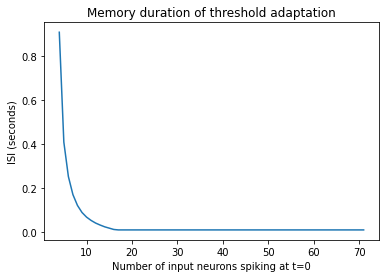

In [12]:
plt.plot(recovery_TA)
plt.xlabel('Number of input neurons spiking at t=0')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of threshold adaptation');

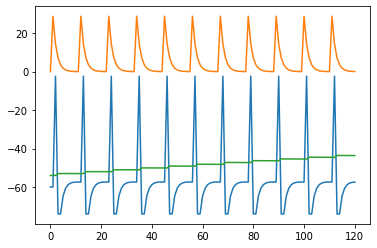

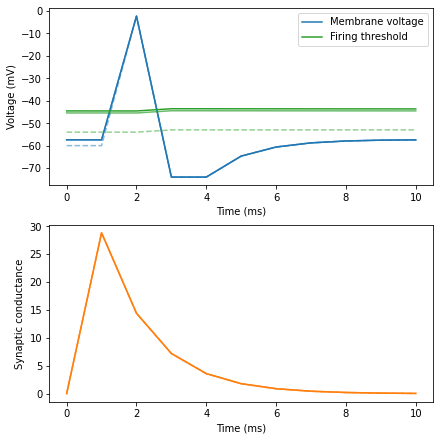

In [13]:
plt.plot(recovery_TA_data[-1]['V']/mV)
plt.plot(recovery_TA_data[-1]['g'])
plt.plot(recovery_TA_data[-1]['th']/mV);
plot_explanatory_figure(params, recovery_TA[-1], 10, **recovery_TA_data[-1])

Still a disappointing result, but before addressing this, let's have a look at STD.

In [14]:
recovery_STD, recovery_STD_data = get_recovery_time(
    {**params, 'th_ampl': 0*mV}, np.arange(max_indegree)+1, 10, get_singular_input,
    isi=params['tau_rec'], record=('v', 'g_exc'))

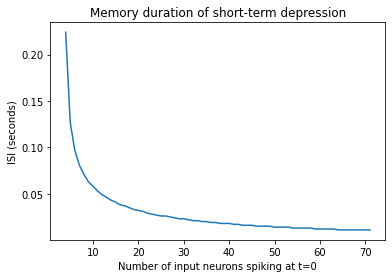

In [15]:
plt.plot(recovery_STD)
plt.xlabel('Number of input neurons spiking at t=0')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of short-term depression');

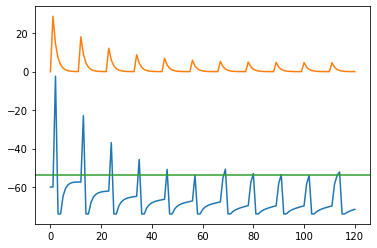

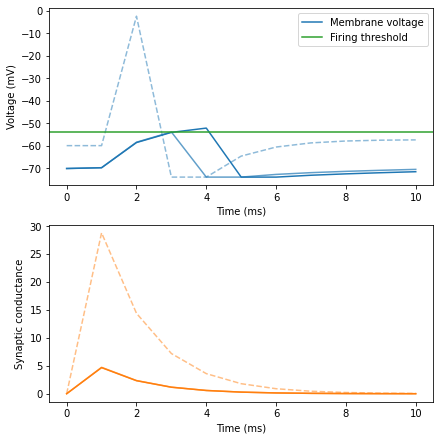

In [16]:
plt.plot(recovery_STD_data[-1]['V']/mV)
plt.plot(recovery_STD_data[-1]['g'])
plt.axhline(recovery_STD_data[-1]['th']/mV, c='C2');
plot_explanatory_figure(params, recovery_STD[-1], 10, **recovery_STD_data[-1])

Let's get a little more realistic. Spread the inputs over 30 ms, and vary spike rate alongside input size.

In [17]:
scattered_spikes = {}

def get_scattered_input(N_inputs, period, N_ticks, pspike, dt, rng=None):
    if N_inputs not in scattered_spikes:
        scattered_spikes[N_inputs] = get_scattered_spikes(N_ticks, N_inputs, pspike, dt, rng)
    return SpikeGeneratorGroup(N_inputs, *scattered_spikes[N_inputs], period=period, name='Input')

def get_scattered_spikes(N_ticks, N_inputs, pspike, dt, rng=None):
    rng = rng or np.random.default_rng()
    while True:
        i = rng.choice(N_inputs, int(N_inputs*pspike))
        t = rng.choice(N_ticks, int(N_inputs*pspike))
        q = np.zeros((N_inputs, N_ticks))
        np.add.at(q, (i, t), 1)
        if not np.any(q>1):
            return i, t*dt

from functools import partial

In [18]:
scattered_recovery_TA, scattered_recovery_TA_data = get_recovery_time(
    {**params, 'tau_rec': 0*ms}, np.arange(max_indegree)+1, 10, partial(get_scattered_input, N_ticks=30, pspike=1, dt=params['dt']),
    isi=params['th_tau'], min_isi=30*params['dt'], record=('v', 'g_exc', 'th_adapt'))

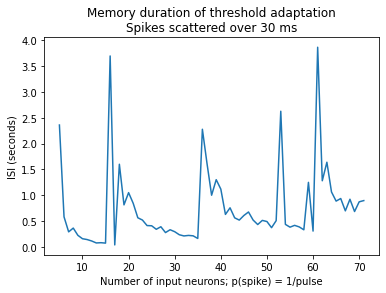

In [19]:
plt.plot(scattered_recovery_TA)
plt.xlabel('Number of input neurons; p(spike) = 1/pulse')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of threshold adaptation\nSpikes scattered over 30 ms');

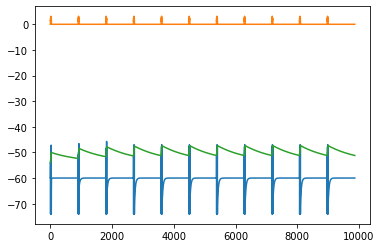

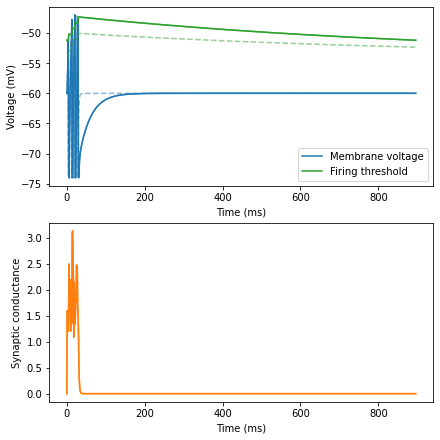

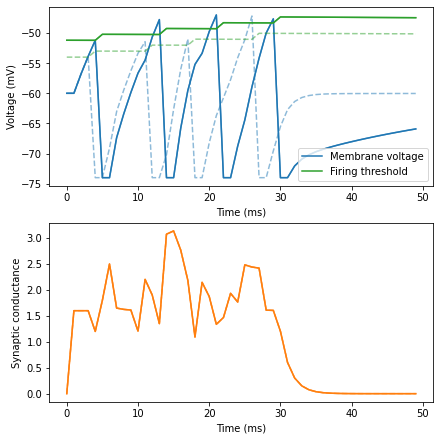

In [20]:
plt.plot(scattered_recovery_TA_data[-1]['V']/mV)
plt.plot(scattered_recovery_TA_data[-1]['g'])
plt.plot(scattered_recovery_TA_data[-1]['th']/mV);
plot_explanatory_figure(params, scattered_recovery_TA[-1], 10, **scattered_recovery_TA_data[-1])
plot_explanatory_figure(params, scattered_recovery_TA[-1], 10, **scattered_recovery_TA_data[-1], tmax=50*ms)

In [21]:
scattered_recovery_STD, scattered_recovery_STD_data = get_recovery_time(
    {**params, 'th_ampl': 0*mV}, np.arange(max_indegree)+1, 10, partial(get_scattered_input, N_ticks=30, pspike=1, dt=params['dt']),
    isi=params['tau_rec'], min_isi=30*params['dt'], record=('v', 'g_exc'))

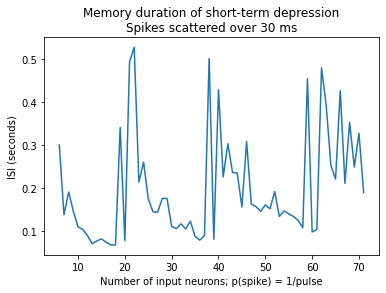

In [22]:
plt.plot(scattered_recovery_STD)
plt.xlabel('Number of input neurons; p(spike) = 1/pulse')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of short-term depression\nSpikes scattered over 30 ms');

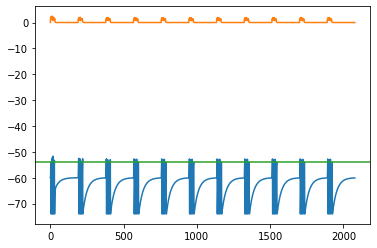

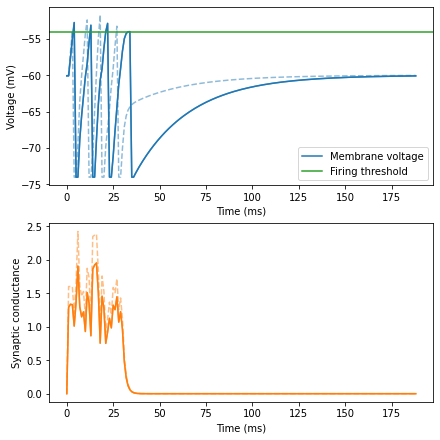

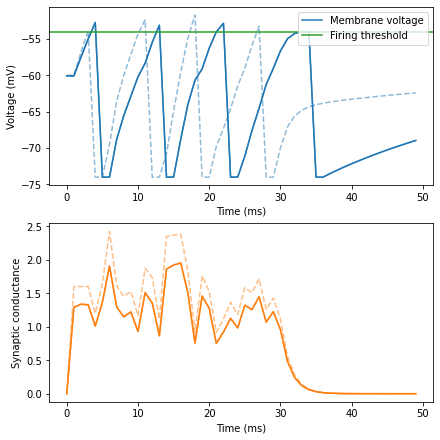

In [23]:
plt.plot(scattered_recovery_STD_data[-1]['V']/mV)
plt.plot(scattered_recovery_STD_data[-1]['g'])
plt.axhline(scattered_recovery_STD_data[-1]['th']/mV, c='C2');
plot_explanatory_figure(params, scattered_recovery_STD[-1], 10, **scattered_recovery_STD_data[-1])
plot_explanatory_figure(params, scattered_recovery_STD[-1], 10, **scattered_recovery_STD_data[-1], tmax=50*ms)

Let's try this across a number of spike probabilities:

In [24]:
def get_recovery_time_2D(params, N_inputs, N_pulses, pspike, input_creation_fn, **kwargs):
    recovery_time = []
    recovery_data = []
    for p in pspike:
        print(p)
        scattered_spikes.clear()
        rec, rec_data = get_recovery_time(params, N_inputs, N_pulses, partial(input_creation_fn, pspike=p), **kwargs)
        recovery_time.append(rec/second)
        recovery_data.append(rec_data)
    return np.asarray(recovery_time)*second, recovery_data

In [25]:
pspike = np.arange(0.2, 2.1, 0.2)
N_inputs = np.arange(max_indegree)+1

In [26]:
pscattered_recovery_TA, pscattered_recovery_TA_data = get_recovery_time_2D(
    {**params, 'tau_rec': 0*ms}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
    isi=params['th_tau'], min_isi=30*params['dt'], record=('v', 'g_exc', 'th_adapt'))

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


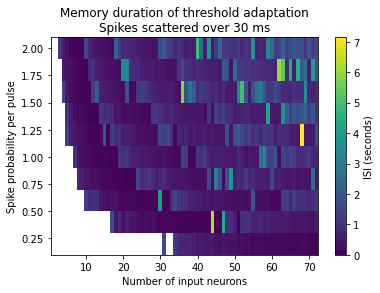

In [27]:
plt.pcolormesh(N_inputs, pspike, pscattered_recovery_TA/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of threshold adaptation\nSpikes scattered over 30 ms');

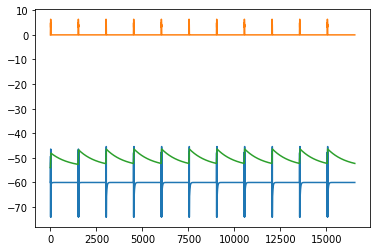

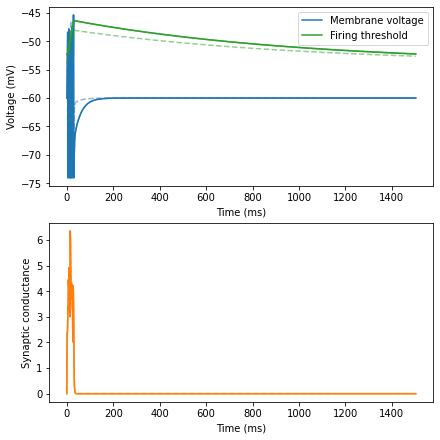

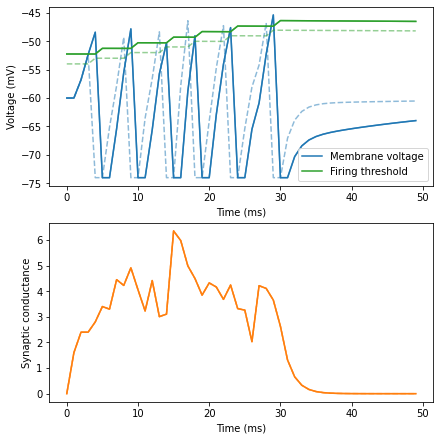

In [28]:
plt.plot(pscattered_recovery_TA_data[-1][-1]['V']/mV)
plt.plot(pscattered_recovery_TA_data[-1][-1]['g'])
plt.plot(pscattered_recovery_TA_data[-1][-1]['th']/mV);
plot_explanatory_figure(params, pscattered_recovery_TA[-1, -1], 10, **pscattered_recovery_TA_data[-1][-1])
plot_explanatory_figure(params, pscattered_recovery_TA[-1, -1], 10, **pscattered_recovery_TA_data[-1][-1], tmax=50*ms)

In [29]:
pscattered_recovery_STD, pscattered_recovery_STD_data = get_recovery_time_2D(
    {**params, 'th_ampl': 0*mV}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
    isi=params['tau_rec'], min_isi=30*params['dt'], record=('v', 'g_exc'))

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


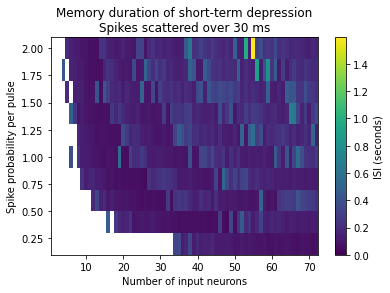

In [30]:
plt.pcolormesh(N_inputs, pspike, pscattered_recovery_STD/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of short-term depression\nSpikes scattered over 30 ms');

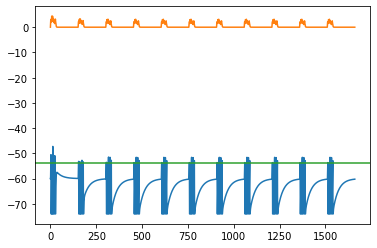

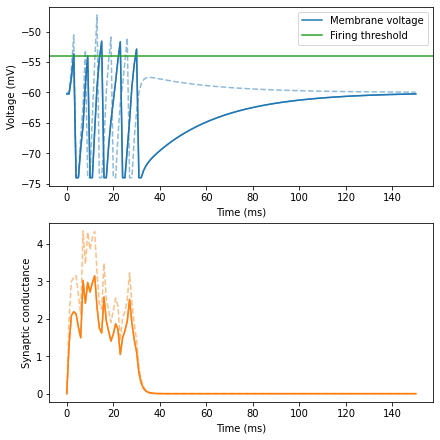

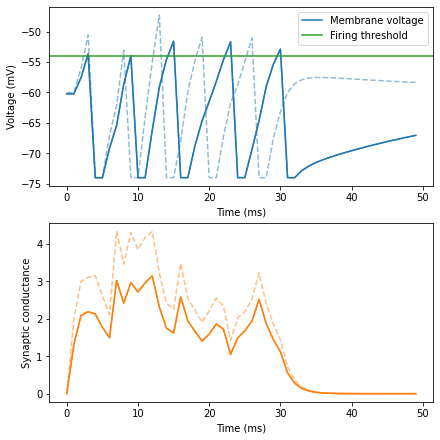

In [31]:
plt.plot(pscattered_recovery_STD_data[-1][-1]['V']/mV)
plt.plot(pscattered_recovery_STD_data[-1][-1]['g'])
plt.axhline(pscattered_recovery_STD_data[-1][-1]['th']/mV, c='C2');
plot_explanatory_figure(params, pscattered_recovery_STD[-1, -1], 10, **pscattered_recovery_STD_data[-1][-1])
plot_explanatory_figure(params, pscattered_recovery_STD[-1, -1], 10, **pscattered_recovery_STD_data[-1][-1], tmax=50*ms)

And one more: Let's do this with exact matching.

In [32]:
xpscattered_recovery_TA, xpscattered_recovery_TA_data = get_recovery_time_2D(
    {**params, 'tau_rec': 0*ms}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
    isi=params['th_tau'], min_isi=30*params['dt'], record=('v', 'g_exc', 'th_adapt'), exact=True)

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


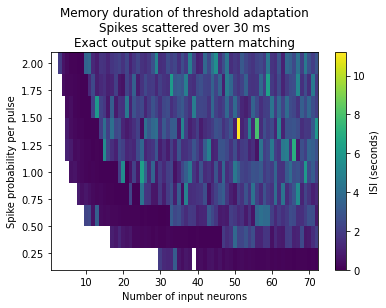

In [33]:
plt.pcolormesh(N_inputs, pspike, xpscattered_recovery_TA/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of threshold adaptation\nSpikes scattered over 30 ms\nExact output spike pattern matching');

WARNING    /tmp/ipykernel_855161/1293930776.py:2: RuntimeWarning: Mean of empty slice
  axs[0].plot(N_inputs, np.nanmean(xpscattered_recovery_TA, 0)/second)
 [py.warnings]


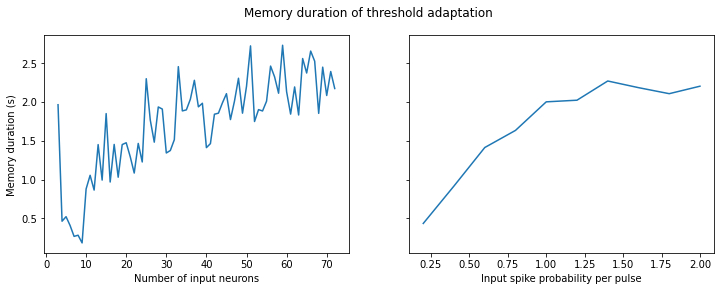

In [43]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True)
axs[0].plot(N_inputs, np.nanmean(xpscattered_recovery_TA, 0)/second)
axs[0].set_xlabel('Number of input neurons')
axs[0].set_ylabel('Memory duration (s)')
axs[1].plot(pspike, np.nanmean(xpscattered_recovery_TA, 1)/second)
axs[1].set_xlabel('Input spike probability per pulse')
fig.suptitle('Memory duration of threshold adaptation');

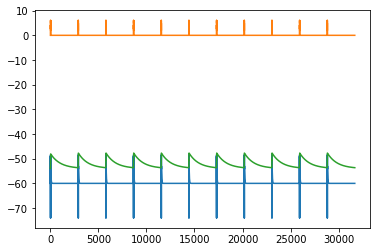

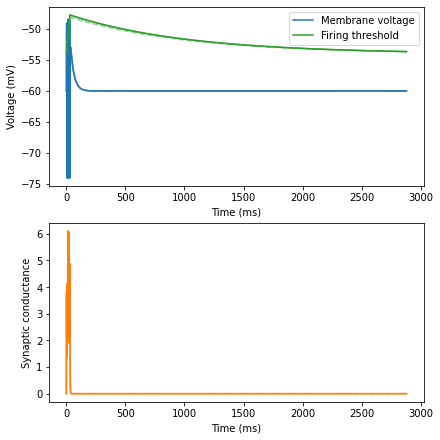

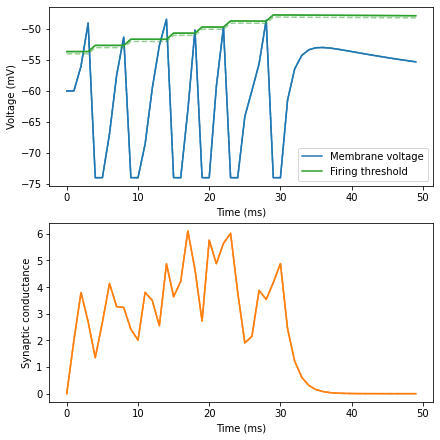

In [34]:
plt.plot(xpscattered_recovery_TA_data[-1][-1]['V']/mV)
plt.plot(xpscattered_recovery_TA_data[-1][-1]['g'])
plt.plot(xpscattered_recovery_TA_data[-1][-1]['th']/mV);
plot_explanatory_figure(params, xpscattered_recovery_TA[-1, -1], 10, **xpscattered_recovery_TA_data[-1][-1])
plot_explanatory_figure(params, xpscattered_recovery_TA[-1, -1], 10, **xpscattered_recovery_TA_data[-1][-1], tmax=50*ms)

In [35]:
xpscattered_recovery_STD, xpscattered_recovery_STD_data = get_recovery_time_2D(
    {**params, 'th_ampl': 0*mV}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
    isi=params['tau_rec'], min_isi=30*params['dt'], record=('v', 'g_exc'), exact=True)

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


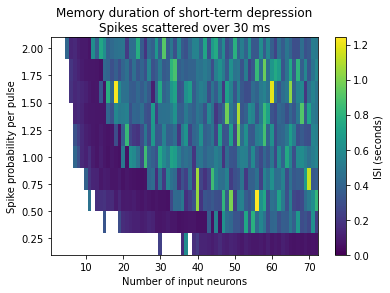

In [36]:
plt.pcolormesh(N_inputs, pspike, xpscattered_recovery_STD/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of short-term depression\nSpikes scattered over 30 ms');

WARNING    /tmp/ipykernel_855161/1095840361.py:2: RuntimeWarning: Mean of empty slice
  axs[0].plot(N_inputs, np.nanmean(xpscattered_recovery_STD, 0)/second)
 [py.warnings]


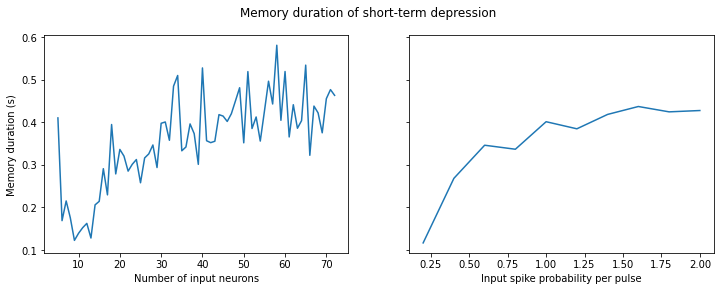

In [45]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True)
axs[0].plot(N_inputs, np.nanmean(xpscattered_recovery_STD, 0)/second)
axs[0].set_xlabel('Number of input neurons')
axs[0].set_ylabel('Memory duration (s)')
axs[1].plot(pspike, np.nanmean(xpscattered_recovery_STD, 1)/second)
axs[1].set_xlabel('Input spike probability per pulse')
fig.suptitle('Memory duration of short-term depression');

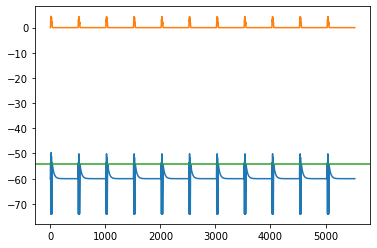

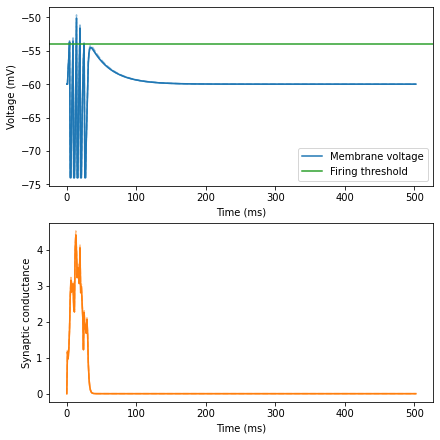

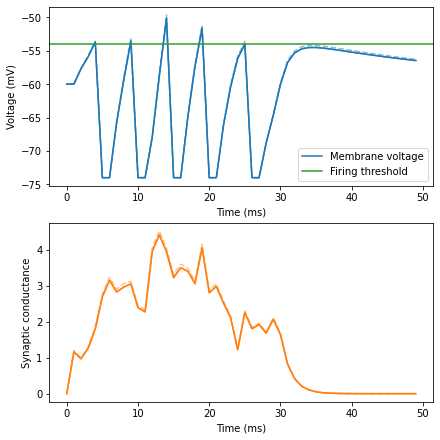

In [37]:
plt.plot(xpscattered_recovery_STD_data[-1][-1]['V']/mV)
plt.plot(xpscattered_recovery_STD_data[-1][-1]['g'])
plt.axhline(xpscattered_recovery_STD_data[-1][-1]['th']/mV, c='C2');
plot_explanatory_figure(params, xpscattered_recovery_STD[-1, -1], 10, **xpscattered_recovery_STD_data[-1][-1])
plot_explanatory_figure(params, xpscattered_recovery_STD[-1, -1], 10, **xpscattered_recovery_STD_data[-1][-1], tmax=50*ms)

In [38]:
dd.io.save('data/memory_duration.h5', dict(
    recovery_TA=recovery_TA, recovery_TA_data=recovery_TA_data,
    recovery_STD=recovery_STD, recovery_STD_data=recovery_STD_data,
    scattered_recovery_TA=scattered_recovery_TA, scattered_recovery_TA_data=scattered_recovery_TA_data,
    scattered_recovery_STD=scattered_recovery_STD, scattered_recovery_STD_data=scattered_recovery_STD_data,
    pscattered_recovery_TA=pscattered_recovery_TA, pscattered_recovery_TA_data=pscattered_recovery_TA_data,
    pscattered_recovery_STD=pscattered_recovery_STD, pscattered_recovery_STD_data=pscattered_recovery_STD_data,
    xpscattered_recovery_TA=xpscattered_recovery_TA, xpscattered_recovery_TA_data=xpscattered_recovery_TA_data,
    xpscattered_recovery_STD=xpscattered_recovery_STD, xpscattered_recovery_STD_data=xpscattered_recovery_STD_data
))